<a href="https://colab.research.google.com/github/AkkapakaManikanta/CIFAR10/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import requests
from PIL import Image
import PIL                             

In [ ]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear = 10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))
                                ])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5),(0.5))
                                ])
training_dataset = datasets.CIFAR10(root = './data', train = True, download = True, transform= transform_train)
validation_dataset = datasets.CIFAR10(root= './data', train = False , download = True, transform =transform)
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle= True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 100, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

In [ ]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0, 1)
  return image

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

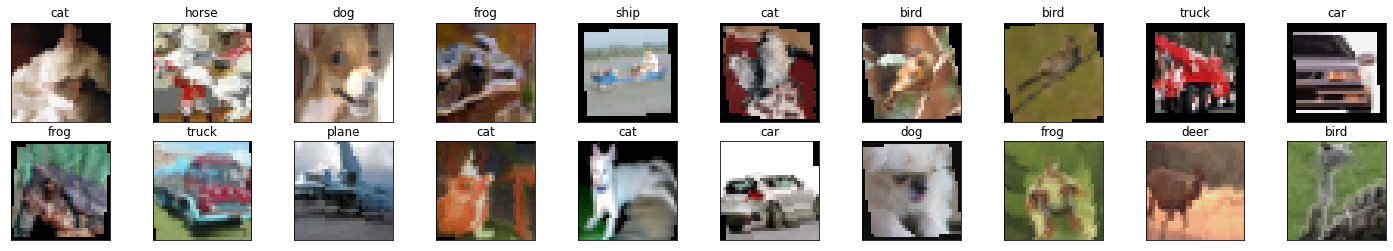

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize= (25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks= [], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x) # as we will be using nn.CrossEntropyLoss to compute loss for multiclass clasiifier
                        #simply make sure that output returned in the end is raw output (the score)
                        # such that softmax activation function is applied to it
    return x

In [ ]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)

    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)

    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch :', e+1)
    print('training loss : {:.4f} , acc: {:.4f}'.format(epoch_loss,epoch_acc.item()))
    print('validation loss : {:.4f} , acc: {:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

epoch : 1
training loss : 1.6995 , acc: 37.8220
validation loss : 1.4040 , acc: 49.1000
epoch : 2
training loss : 1.3900 , acc: 49.9180
validation loss : 1.2365 , acc: 55.8000
epoch : 3
training loss : 1.2630 , acc: 54.8040
validation loss : 1.1275 , acc: 59.6100
epoch : 4
training loss : 1.1688 , acc: 58.3960
validation loss : 1.0532 , acc: 62.7300
epoch : 5
training loss : 1.1004 , acc: 60.7000
validation loss : 1.0072 , acc: 64.4200
epoch : 6
training loss : 1.0396 , acc: 63.4460
validation loss : 0.9685 , acc: 65.9900
epoch : 7
training loss : 0.9993 , acc: 64.9320
validation loss : 0.9069 , acc: 67.9900
epoch : 8
training loss : 0.9642 , acc: 65.9820
validation loss : 0.8662 , acc: 69.5400
epoch : 9
training loss : 0.9336 , acc: 67.2400
validation loss : 0.8616 , acc: 69.9400
epoch : 10
training loss : 0.9065 , acc: 68.2720
validation loss : 0.8903 , acc: 69.5700
epoch : 11
training loss : 0.8925 , acc: 68.8820
validation loss : 0.8455 , acc: 71.1600
epoch : 12
training loss : 0.8

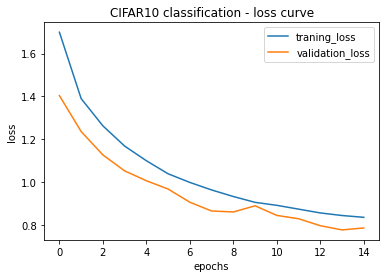

In [ ]:
plt.plot(running_loss_history,label = 'traning_loss')
plt.plot(val_running_loss_history,label = 'validation_loss')
plt.legend()
plt.title('CIFAR10 classification - loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

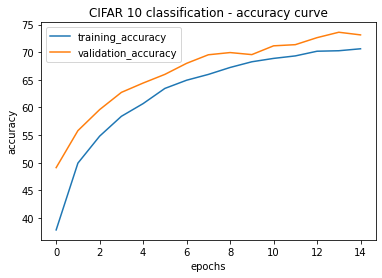

In [ ]:
plt.plot(running_corrects_history, label = 'training_accuracy')
plt.plot(val_running_corrects_history, label = 'validation_accuracy')
plt.legend()
plt.title('CIFAR 10 classification - accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

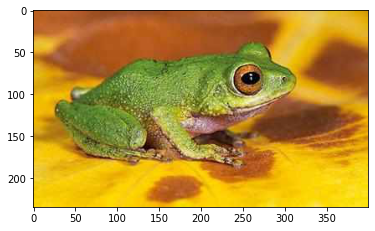

In [ ]:
import requests
from PIL import Image
import PIL
url = 'https://static.toiimg.com/thumb/msid-81319557,imgsize-41121,width-400,resizemode-4/81319557.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

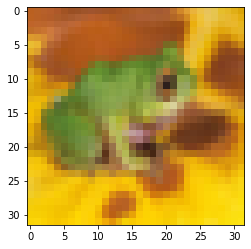

In [ ]:
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

frog


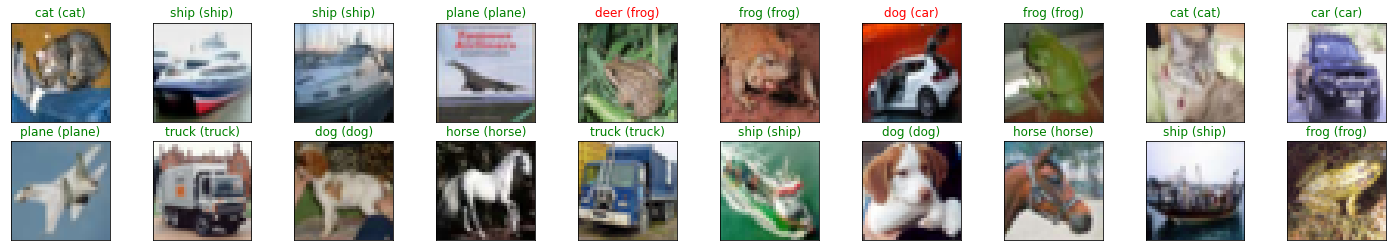

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize= (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks= [], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ('green' if preds[idx].item() == labels[idx].item() else 'red'))